In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalAE import MeanFieldVariationalAE2
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Target density #

In [3]:
ndist= torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(1),torch.diag(torch.Tensor([1.])))
nndist= torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(1),torch.diag(torch.Tensor([0.01])))
def GenNormal_log_prob(x,beta=torch.Tensor([8.])):
    return -(-nndist.log_prob(x)).pow(beta/2)
def GenNormal_log_prob_(x0,x1,mu=torch.Tensor([0.]),scale=torch.Tensor([1.]),beta=torch.Tensor([8.])):
    #rotate 45°
    x_0=0.5*x0-0.5*x1
    x_1=0.5*x0+0.5*x1
    return -((x_0-mu)**2/scale**2).pow(beta/2)+nndist.log_prob(x_1)#-((x1-mu[1])**2/scale**2).pow(beta/2)
def logtarget(x_0,x_1):
    return GenNormal_log_prob_(x_0,x_1)

In [4]:
%matplotlib notebook


x=y=torch.arange(-2.,2.,0.05)
grid_x, grid_y = torch.meshgrid(x, y)
p=torch.Tensor(grid_x.shape)

for i in range(p.shape[0]):
    for j in range(p.shape[1]):
        #x=torch.Tensor([grid_x[i,j],grid_y[i,j]]).unsqueeze(0)
        p[i,j]=GenNormal_log_prob_(grid_x[i,j],grid_y[i,j]).squeeze(-1)



<IPython.core.display.Javascript object>


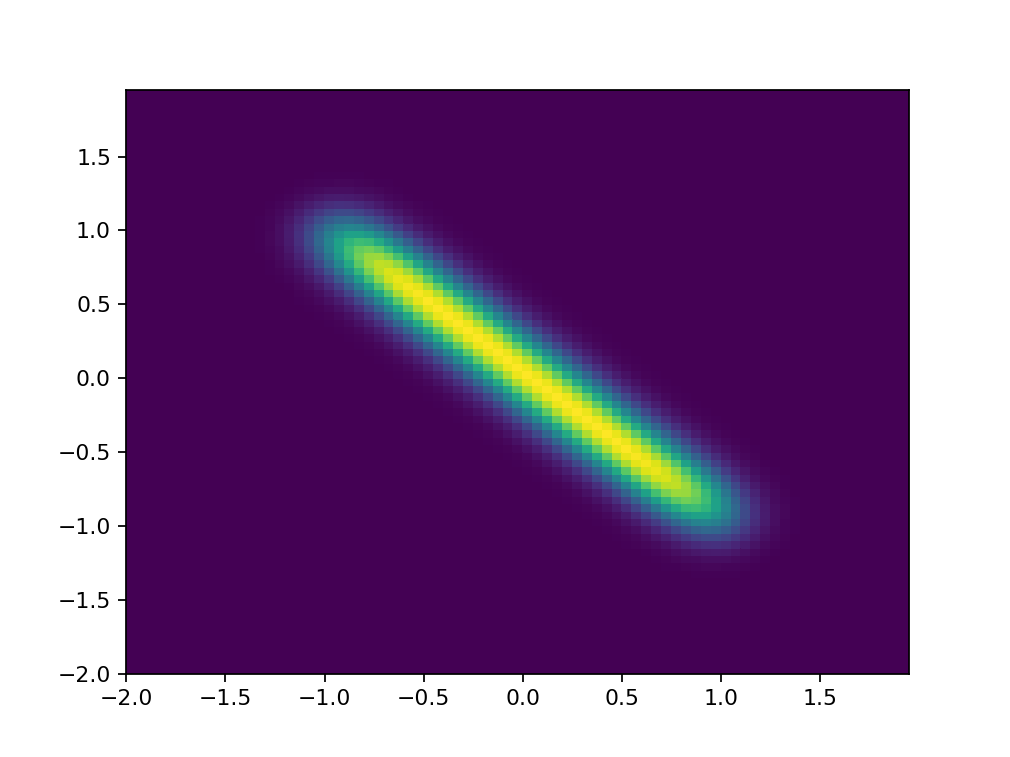

In [5]:
%matplotlib notebook
plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())
plt.show()

# AE-Variational Distribution #

In [7]:
nb_latent=2
VAE = MeanFieldVariationalAE(nb_latent,2,2,2,extraLayer=True,activation=nn.Sigmoid())
VAE_param_count = get_param(VAE).shape[0]
VAE

MeanFieldVariationalAE(
  (mfvar): MeanFieldVariationalDistribution()
  (layerIn): Linear(in_features=2, out_features=2, bias=True)
  (layerOut): Linear(in_features=2, out_features=2, bias=True)
  (layerMid): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [8]:
VAE.layerIn.weight.data=torch.eye(2)
VAE.layerIn.bias.data=torch.Tensor([0.,0.])
VAE.layerMid.weight.data=torch.eye(2)
VAE.layerMid.bias.data=torch.zeros(2)
VAE.layerOut.weight.data=3*torch.eye(2)
VAE.layerOut.bias.data=torch.Tensor([-1.5,-1.5])

<IPython.core.display.Javascript object>


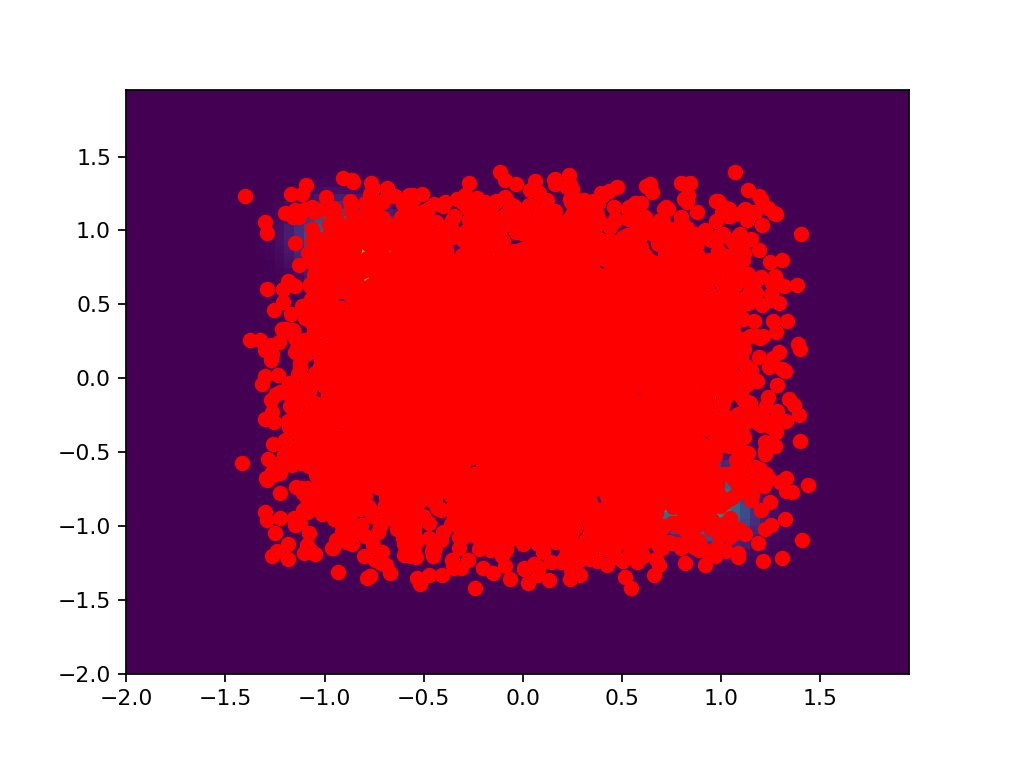

In [9]:
%matplotlib notebook


Z = torch.Tensor(5000,2)
for i in range(5000):
    z = VAE()
    Z[i]=z.detach().clone().cpu().squeeze()
#print(Z)

plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())
plt.scatter(Z[:,0],Z[:,1],color='red') 


In [10]:
def KLDivGauss(mu,sigma):
    Div=sigma+mu**2-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [11]:
n_samples_VAR = 200

In [12]:
optimizer = torch.optim.Adam(VAE.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

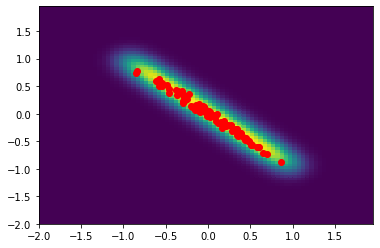

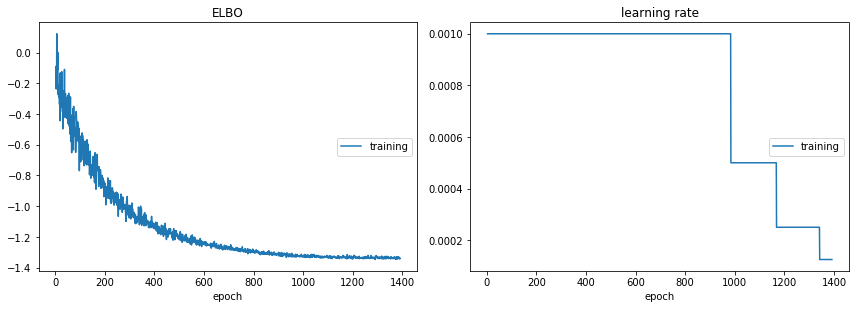

ELBO:
training   (min:   -1.348, max:    0.173, cur:   -1.340)

learning rate:
training   (min:    0.000, max:    0.001, cur:    0.000)


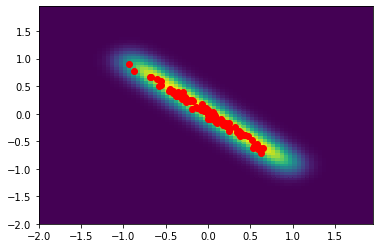

In [14]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    
    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        theta = VAE().squeeze(0)
        LL[i]=GenNormal_log_prob_(theta[0],theta[1])
    L = Div - LL.mean()

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()
    
    optimizer.step()
    
    if t %10 == 0:    
        Z = torch.Tensor(100,2)
        for i in range(100):
            Z[i]=VAE().detach().clone().cpu().squeeze()
        plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())
        plt.scatter(Z[:,0],Z[:,1],color='red') 
    
    
    
    if learning_rate < 0.0001:
        break

<IPython.core.display.Javascript object>


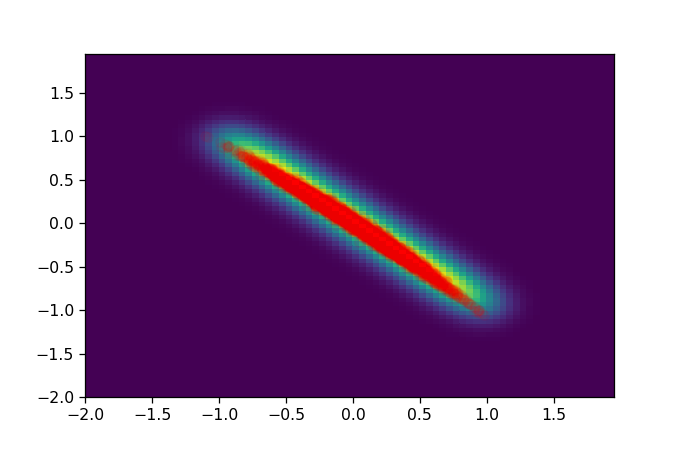

In [26]:
%matplotlib notebook
%matplotlib notebook


Z = torch.Tensor(5000,2)
for i in range(5000):
    z = VAE()
    Z[i]=z.detach().clone().cpu().squeeze()

plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())  
plt.scatter(Z[:,0],Z[:,1],color='red',alpha=0.05) 


# Variational Mean Field #

In [19]:
q = MeanFieldVariationalDistribution(2)

In [20]:
n_samples_ELBO = 200
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

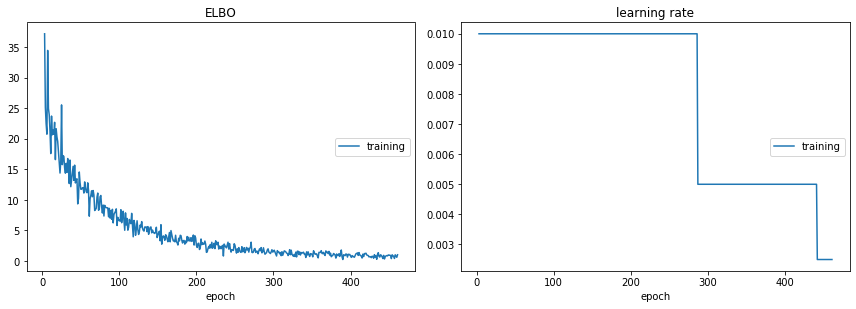

ELBO:
training   (min:    0.223, max:   37.186, cur:    0.998)

learning rate:
training   (min:    0.003, max:    0.010, cur:    0.003)


KeyboardInterrupt: 

In [21]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    LQ=torch.Tensor(n_samples_ELBO)
    LP=torch.Tensor(n_samples_ELBO)
    for i in range(n_samples_ELBO):
        z = q.sample()
        LQ[i] = q.log_prob(z)
        LP[i] = GenNormal_log_prob_(z.squeeze()[0],z.squeeze()[1])
    
    L = (LQ - LP).mean()

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break


<IPython.core.display.Javascript object>


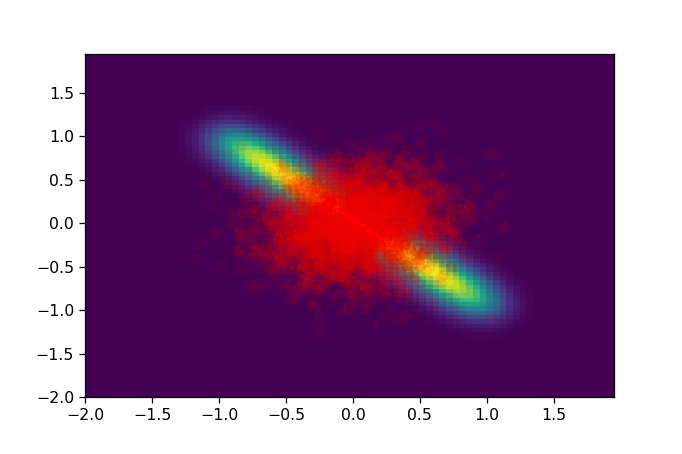

In [25]:
%matplotlib notebook
%matplotlib notebook

Z = q.sample(5000).detach().numpy()

plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())  
plt.scatter(Z[:,0],Z[:,1],color='red',alpha=0.05) 